In [11]:
import os
import pickle

from torch.utils.data import DataLoader

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
from matching.glema.experimental.dataset import BaseDataset, collate_fn

In [12]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm"
args.directed = False
args.anchored = False
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [13]:
dataset_name = model_utils.get_dataset_name( args )
data_path = io_utils.get_abs_file_path( os.path.join( args.data_processed_dir, dataset_name ) )
data_path

'/Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/data/data_processed/CPG_augm'

In [14]:
key_file = os.path.join( data_path, args.test_keys if args.test_data else args.train_keys )
with open( key_file, "rb" ) as fp:
    keys = pickle.load( fp )
print( f"Number of data points: {len( keys )}" )
iso_key_idxs = [ i for i, k in enumerate( keys ) if "iso" in k ]
non_iso_key_idxs = [ i for i, k in enumerate( keys ) if "non" in k ]
print( f"Data point split: iso [{len( iso_key_idxs )}] / noniso [{len( non_iso_key_idxs )}]" )

Number of data points: 11648
Data point split: iso [5903] / noniso [5745]


In [15]:
complexity_keys = model_utils.load_complexity_keys( args, train=not args.test_data )
dataset = BaseDataset( keys, args, k_start=1, k_keys=complexity_keys )
dataset.remove_complexity_limit()

Removed graph sample complexity limit


In [16]:
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}


def get_sample( dataset, sample_idx, relabel=True ):
    sample_data = dataset.get_data( sample_idx )
    pos_source, pos_query, pos_mapping, neg_source, neg_query, neg_mapping = sample_data
    pos_mapping = { qnid: snid for qnid, snid in pos_mapping }
    neg_mapping = { qnid: snid for qnid, snid in neg_mapping }
    if relabel:
        pos_query = graph_utils.relabel_nodes( pos_query, pos_mapping )
        neg_query = graph_utils.relabel_nodes( neg_query, neg_mapping )
    return pos_source, pos_query, pos_mapping, neg_source, neg_query, neg_mapping


def get_colors( G ):
    return [ "purple" if d[ "anchor" ] == 1 else "grey" for n, d in G.nodes( data=True ) ]

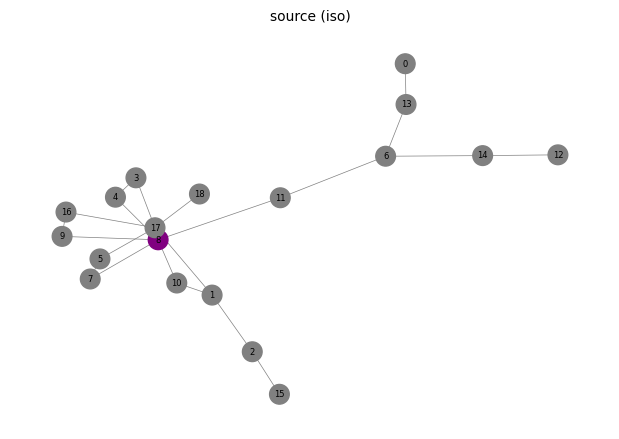

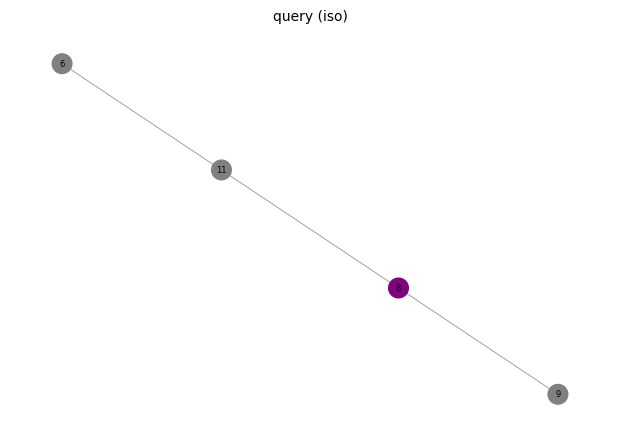

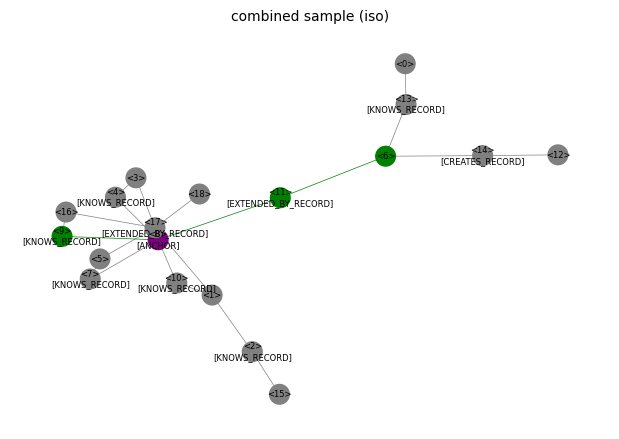

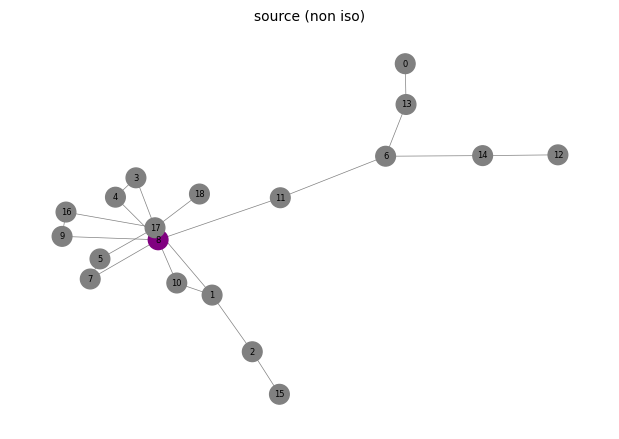

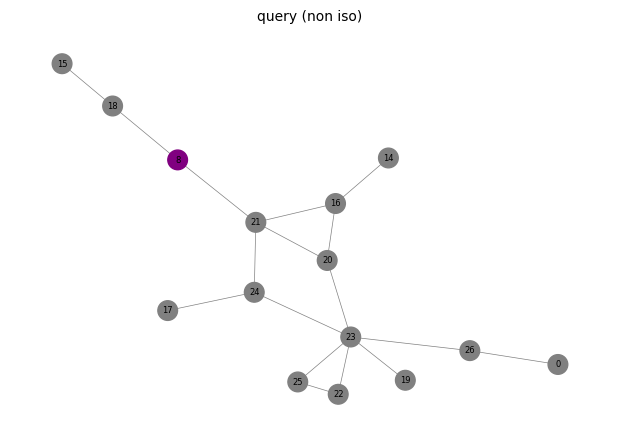

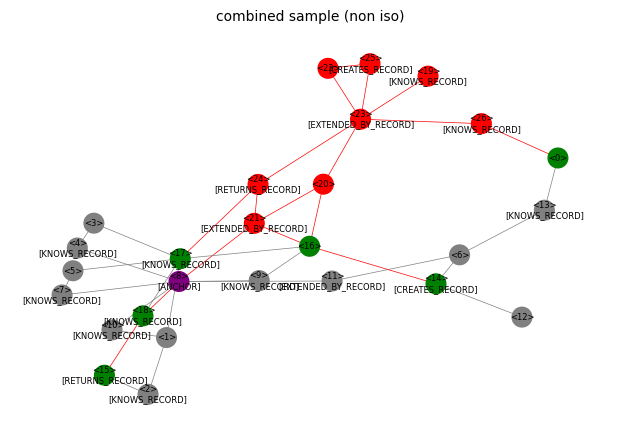

In [17]:
sample_idx = iso_key_idxs[ 0 ]
pos_source, pos_query, _, neg_source, neg_query, _ = get_sample( dataset, sample_idx )

plot_utils.plot_graph( title="source (iso)", graph=pos_source, nodeColors=get_colors( pos_source ) )
plot_utils.plot_graph( title="query (iso)", graph=pos_query, nodeColors=get_colors( pos_query ) )
pos_combined, pos_n_colors, pos_e_colors = graph_utils.combine_graph( pos_source, pos_query,
                                                                      matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (iso)", graph=pos_combined,
    nodeColors=pos_n_colors, edgeColors=pos_e_colors,
    nodeLabels=graph_utils.get_node_labels( pos_combined )
)

plot_utils.plot_graph( title="source (non iso)", graph=neg_source, nodeColors=get_colors( neg_source ) )
plot_utils.plot_graph( title="query (non iso)", graph=neg_query, nodeColors=get_colors( neg_query ) )
neg_combined, neg_n_colors, neg_e_colors = graph_utils.combine_graph( neg_source, neg_query,
                                                                      matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (non iso)", graph=neg_combined,
    nodeColors=neg_n_colors, edgeColors=neg_e_colors,
    nodeLabels=graph_utils.get_node_labels( neg_combined )
)

In [18]:
sample = dataset.__getitem__( sample_idx )
collate_fn( [ sample ] )

(Batch(G=[1], anchor=[19], batch=[19], edge_index=[2, 42], edge_label_index=[2, 42], label=[42], node_feature=[19, 1], node_label_index=[19]),
 Batch(G=[1], anchor=[4], batch=[4], edge_index=[2, 6], edge_label_index=[2, 6], label=[6], node_feature=[4, 1], node_label_index=[4]),
 Batch(G=[1], anchor=[19], batch=[19], edge_index=[2, 42], edge_label_index=[2, 42], label=[42], node_feature=[19, 1], node_label_index=[19]),
 Batch(G=[1], anchor=[15], batch=[15], edge_index=[2, 34], edge_label_index=[2, 34], label=[34], node_feature=[15, 1], node_label_index=[15]))

In [19]:
dataloader = DataLoader(
    dataset,
    2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    # sampler = train_sampler
)

In [20]:
for sample in dataloader:
    pos_sources, pos_queries, neg_sources, neg_queries = sample
    print( pos_sources )
    print( pos_queries )
    print( neg_sources )
    print( neg_queries )
    break

Batch(G=[2], anchor=[38], batch=[38], edge_index=[2, 84], edge_label_index=[2, 84], label=[84], node_feature=[38, 1], node_label_index=[38])
Batch(G=[2], anchor=[6], batch=[6], edge_index=[2, 8], edge_label_index=[2, 8], label=[8], node_feature=[6, 1], node_label_index=[6])
Batch(G=[2], anchor=[38], batch=[38], edge_index=[2, 84], edge_label_index=[2, 84], label=[84], node_feature=[38, 1], node_label_index=[38])
Batch(G=[2], anchor=[23], batch=[23], edge_index=[2, 50], edge_label_index=[2, 50], label=[50], node_feature=[23, 1], node_label_index=[23])
